In [101]:
import pandas as pd
import datetime as dt
import re
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim import corpora
from collections import defaultdict
import nltk

from nltk.corpus import stopwords 

from nltk.tokenize import RegexpTokenizer

#sentences
nltk.download('punkt')

#lemmatization
nltk.download('wordnet')

#use nltk to get stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/harman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/harman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
stopwords_english = stopwords.words('english')


In [103]:
import string
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [104]:
subreddit = 'louisiana'

In [105]:
df = pd.read_csv('data/'+subreddit+'_data.csv')


In [106]:
len(df)
data_top = df.head() 
data_top

,id_comment,author_comment,body,link_id,parent_id,subreddit_comment,subreddit_id,name,created_utc_comment,id_submission,...,subreddit_submission,created_utc_submission,url,num_comments,score,selftext,is_power_related,is_hurricane_related,date_comment,date_submission
0,h7c7j2o,[deleted],"No apologies needed, I appreciated the interac...",ovugu8,t1_h7c6t2h,Louisiana,t5_2qr93,t1_h7c7j2o,1.627842e+09,ovugu8,...,Louisiana,1.627833e+09,https://www.reddit.com/r/Louisiana/comments/ov...,163.0,449.0,"Up to 14 g is a $100 fine only, no jail time. ...",True,False,2021-08-01 18:13:04,2021-08-01 15:46:03
1,h7d0hun,Quiet_Fox_,I've half a mind to move to Colorado but damm ...,ovugu8,t1_h7cso3l,Louisiana,t5_2qr93,t1_h7d0hun,1.627855e+09,ovugu8,...,Louisiana,1.627833e+09,https://www.reddit.com/r/Louisiana/comments/ov...,163.0,449.0,"Up to 14 g is a $100 fine only, no jail time. ...",True,False,2021-08-01 22:04:53,2021-08-01 15:46:03
2,h7d251p,Shadeauxmarie,*Many employers are still full on Reefer Madne...,ovugu8,t1_h7cuz7x,Louisiana,t5_2qr93,t1_h7d251p,1.627856e+09,ovugu8,...,Louisiana,1.627833e+09,https://www.reddit.com/r/Louisiana/comments/ov...,163.0,449.0,"Up to 14 g is a $100 fine only, no jail time. ...",True,False,2021-08-01 22:18:33,2021-08-01 15:46:03
3,h7dcwh0,Shadeauxmarie,I know exactly what drugs are capable of and k...,ovugu8,t1_h7d9xvt,Louisiana,t5_2qr93,t1_h7dcwh0,1.627862e+09,ovugu8,...,Louisiana,1.627833e+09,https://www.reddit.com/r/Louisiana/comments/ov...,163.0,449.0,"Up to 14 g is a $100 fine only, no jail time. ...",True,False,2021-08-01 23:51:02,2021-08-01 15:46:03
4,h7dey5g,athehack,"Okay, sure let’s say nuclear power plant emplo...",ovugu8,t1_h7dcwh0,Louisiana,t5_2qr93,t1_h7dey5g,1.627863e+09,ovugu8,...,Louisiana,1.627833e+09,https://www.reddit.com/r/Louisiana/comments/ov...,163.0,449.0,"Up to 14 g is a $100 fine only, no jail time. ...",True,False,2021-08-02 00:09:23,2021-08-01 15:46:03


In [107]:
df = df[['id_comment', 'author_comment','body','parent_id', 'date_comment']]
print(df.head())


  id_comment author_comment  \
0    h7c7j2o      [deleted]   
1    h7d0hun     Quiet_Fox_   
2    h7d251p  Shadeauxmarie   
3    h7dcwh0  Shadeauxmarie   
4    h7dey5g       athehack   

                                                body   parent_id  \
0  No apologies needed, I appreciated the interac...  t1_h7c6t2h   
1  I've half a mind to move to Colorado but damm ...  t1_h7cso3l   
2  *Many employers are still full on Reefer Madne...  t1_h7cuz7x   
3  I know exactly what drugs are capable of and k...  t1_h7d9xvt   
4  Okay, sure let’s say nuclear power plant emplo...  t1_h7dcwh0   

          date_comment  
0  2021-08-01 18:13:04  
1  2021-08-01 22:04:53  
2  2021-08-01 22:18:33  
3  2021-08-01 23:51:02  
4  2021-08-02 00:09:23  


In [108]:
df_p = df.reset_index().groupby("parent_id",as_index=False)['body'].apply(lambda x: ','.join(x))
p_threads = df_p.values

df_p_threads = pd.DataFrame(p_threads)
df_p_threads.rename(columns={0: "comment_thread", 1: "text"},inplace=True)

In [109]:
df_p_threads['text']
def first_pass(text): 
    text = str(text)
    #remove newline character code
    text = text.replace('\\n',' ')
    #remove the ampersand character code
    text = text.replace('&amp',' ')
    #character code for a Zero-witdh space, which is a character that acts like a spacebar, except it's invisible
    #https://www.reddit.com/r/OutOfTheLoop/comments/9abjhm/what_does_x200b_mean/
    text = text.replace(';#x200B;',' ')
    #A commonly used character in HTML is the non-breaking space: &nbsp;
    text = text.replace('nbsp',' ')
    
    return text

In [110]:
df_p_threads['clean_text'] = df_p_threads.text.apply(first_pass)


In [111]:
def second_pass(text): 
    #make string lowercase 
    text = str(text)
    text = text.lower()
    
    #remove links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

    #tokenize
    #create bag of words
    #1-grams 
    tokens = nltk.word_tokenize(text) 
    clean_text = []
    
    #remove stopwords, punctuation, then lemmatize
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation): 
            token = wordnet_lemmatizer.lemmatize(word)
            clean_text.append(token)
            
    #remove words of length 3 or smaller        
    clean_text = [token for token in clean_text if len(token) > 3] 
            
    return clean_text

In [112]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/harman/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [113]:
df_p_threads['clean_text'] = df_p_threads.text.apply(second_pass)
df_p_threads.clean_text
docs = df_p_threads.clean_text


In [114]:
docs

0      [apology, needed, appreciated, interaction, tr...
1      [half, mind, move, colorado, damm, living, cos...
2      [many, employer, still, full, reefer, madness,...
3      [care, much, nuclear, power, plant, operator, ...
4      [know, exactly, drug, capable, know, precisely...
                             ...                        
771    [deleted, well, yeah, would, modernize, infras...
772    [lied, raising, second, highest, sale, country...
773    [good, news, right, remember, feeling, seeing,...
774               [even, hear, thank, speaking, deleted]
775    [coworker, said, answer, phone, anymore, like,...
Name: clean_text, Length: 776, dtype: object

In [115]:
dictionary = corpora.Dictionary(docs)
print(len(dictionary))
#saving the dictionary
dictionary.save('nola.dict')
print(dictionary)

5928
Dictionary<5928 unique tokens: ['apology', 'appreciated', 'currently', 'enjoy', 'felony']...>


In [116]:
#create a corpus
corpus = [dictionary.doc2bow(text) for text in docs]
#you can now save the corpus
corpora.MmCorpus.serialize('nola.mm', corpus)
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [117]:
#let's take a look at the words as id in the dictionary
#this is what the BoW looks like
id2word = corpora.Dictionary(docs)
print(id2word[0])
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])



apology
[[('apology', 1), ('appreciated', 1), ('currently', 1), ('enjoy', 1), ('felony', 1), ('interaction', 1), ('needed', 1), ('telling', 1), ('troll', 1)]]


In [118]:
import sklearn
import joblib


In [119]:
get_ipython().run_cell_magic('time', '', '\n# Build LDA model\nimport os\n\n#By setting the chunksize to about 1/10 of the corpus size, \n#you can maintain the processing time under control while \n#comparing across different chunks of text. \n#This becomes important if the \n\n#I am picking 20 topics as the number of topics in the corpus\n\nchunksize = 1000\npasses = 20\nworkers = 6\n\nlda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,\n                                   id2word=id2word,\n                                   num_topics=20, \n                                   random_state=100,\n                                   chunksize=chunksize,\n                                   passes=passes,\n                                   per_word_topics=True,\n                                   workers=workers)')


CPU times: user 13.8 s, sys: 1.71 s, total: 15.5 s
Wall time: 1min 20s


In [120]:
def compute_coherence_values(dictionary, corpus, texts, limit=100, start=10, step=10):
    chunksize = 1000
    passes = 20
    workers = 6
    
    coherence_values = []
    model_list = []
    #setup the LDA model 
    #it is multicore so we can run multiple models together
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics, 
                                   random_state=100,
                                   chunksize=chunksize,
                                   passes=passes,
                                   per_word_topics=True,
                                   workers=workers)
        print('saving the LDA model...')
        Filename = "LDA_Model_"+str(num_topics)+".model"
        model.save(Filename)
        model_list.append(model)
        print('done with model ',str(num_topics))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print('coherence metric is ',str(coherencemodel.get_coherence()))
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [121]:
# Can take a long time to run.
#start from 10 topics
#with a step of 1 topic
#continue adding more topics until we get to 30 topics
limit = 31
start = 10
step  = 1

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)


saving the LDA model...
done with model  10
coherence metric is  0.2920066957345363
saving the LDA model...
done with model  11
coherence metric is  0.30569462593003743
saving the LDA model...
done with model  12
coherence metric is  0.3235258588978395
saving the LDA model...
done with model  13
coherence metric is  0.31906458780676744
saving the LDA model...
done with model  14
coherence metric is  0.27934838775238524
saving the LDA model...
done with model  15
coherence metric is  0.3098781435022552
saving the LDA model...
done with model  16
coherence metric is  0.3148900475713896
saving the LDA model...
done with model  17
coherence metric is  0.31353042339941517
saving the LDA model...
done with model  18
coherence metric is  0.314487990308963
saving the LDA model...
done with model  19
coherence metric is  0.3123629933925429
saving the LDA model...
done with model  20
coherence metric is  0.30261696416816375
saving the LDA model...
done with model  21
coherence metric is  0.30178

In [122]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20,'figure.figsize':(10,8)})

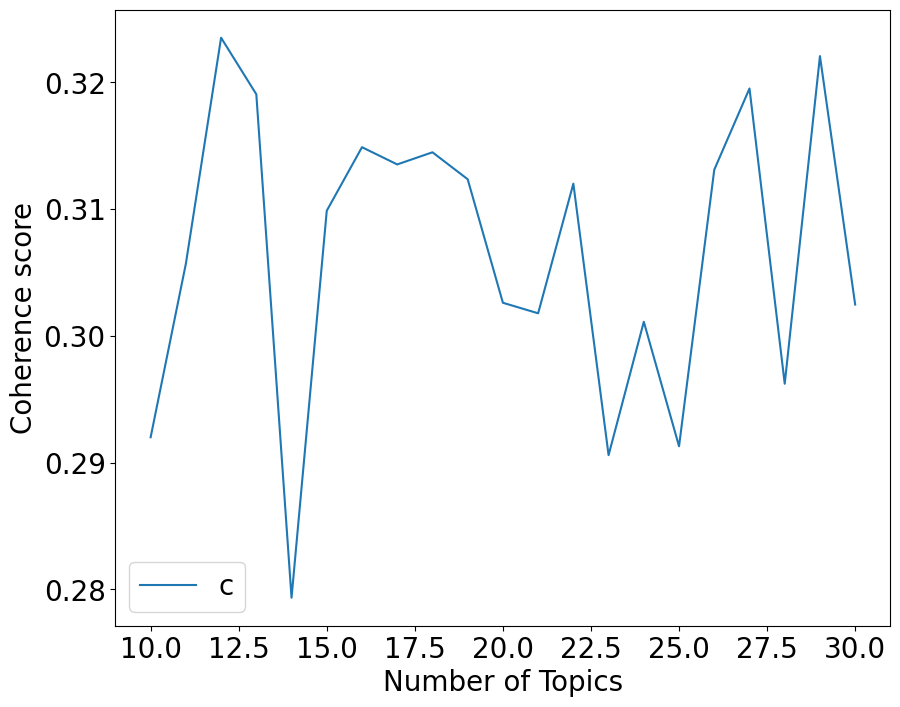

In [123]:
fig = plt.gcf()

limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDA_models_coherence.jpg')


In [124]:
# Print the coherence scores for the models
coherence = zip(x, coherence_values)

sorted_coherence = sorted(coherence, key = lambda x: int(x[1]))

for m, cv in sorted_coherence:
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.292
Num Topics = 11  has Coherence Value of 0.3057
Num Topics = 12  has Coherence Value of 0.3235
Num Topics = 13  has Coherence Value of 0.3191
Num Topics = 14  has Coherence Value of 0.2793
Num Topics = 15  has Coherence Value of 0.3099
Num Topics = 16  has Coherence Value of 0.3149
Num Topics = 17  has Coherence Value of 0.3135
Num Topics = 18  has Coherence Value of 0.3145
Num Topics = 19  has Coherence Value of 0.3124
Num Topics = 20  has Coherence Value of 0.3026
Num Topics = 21  has Coherence Value of 0.3018
Num Topics = 22  has Coherence Value of 0.312
Num Topics = 23  has Coherence Value of 0.2906
Num Topics = 24  has Coherence Value of 0.3011
Num Topics = 25  has Coherence Value of 0.2913
Num Topics = 26  has Coherence Value of 0.3131
Num Topics = 27  has Coherence Value of 0.3195
Num Topics = 28  has Coherence Value of 0.2962
Num Topics = 29  has Coherence Value of 0.3221
Num Topics = 30  has Coherence Value of 0.3025


In [125]:
#pretty print is used to show models in a clean way
import pprint
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=True) 
topics= optimal_model.print_topics(num_words=20) 
topics

[(0,
  '0.016*"louisiana" + 0.014*"state" + 0.012*"year" + 0.010*"people" + 0.009*"good" + 0.008*"live" + 0.007*"moved" + 0.007*"home" + 0.007*"back" + 0.007*"storm" + 0.006*"hurricane" + 0.006*"life" + 0.006*"place" + 0.005*"like" + 0.005*"time" + 0.005*"better" + 0.005*"thing" + 0.005*"stay" + 0.005*"well" + 0.005*"family"'),
 (1,
  '0.011*"would" + 0.010*"like" + 0.008*"internet" + 0.007*"time" + 0.007*"power" + 0.006*"louisiana" + 0.006*"generator" + 0.006*"entergy" + 0.006*"state" + 0.005*"month" + 0.005*"said" + 0.005*"week" + 0.005*"even" + 0.005*"customer" + 0.004*"take" + 0.004*"hurricane" + 0.004*"shit" + 0.004*"year" + 0.004*"back" + 0.004*"keep"'),
 (2,
  '0.011*"power" + 0.007*"back" + 0.007*"line" + 0.005*"like" + 0.005*"know" + 0.005*"thing" + 0.005*"home" + 0.005*"take" + 0.004*"right" + 0.004*"shit" + 0.004*"good" + 0.004*"area" + 0.004*"would" + 0.004*"even" + 0.004*"without" + 0.004*"grid" + 0.004*"louisiana" + 0.003*"else" + 0.003*"storm" + 0.003*"think"'),
 (3,
  '

In [126]:
optimal_model.num_topics


11

In [127]:
# get_ipython().system('pip install pyLDAvis==3.2.2')


In [128]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis #Visualize the topics
#show the visualization in the notebook
pyLDAvis.enable_notebook() 
#create the visualization using the corpus, the optimum model, and the id2word mapping in the dictionary
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
#save the visualization
pyLDAvis.save_html(vis, subreddit+'lda.html')
#show the visualization in the notebook
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.063244  0.081469       1        1  20.298971
0     -0.167982  0.060365       2        1  12.251904
2      0.033270  0.016665       3        1   9.763079
4      0.050025 -0.001162       4        1   9.636364
8      0.046602  0.098634       5        1   9.477665
5      0.022118 -0.035513       6        1   7.784651
1     -0.014364 -0.061991       7        1   6.874562
10    -0.065385  0.005077       8        1   6.625127
7     -0.027661 -0.071537       9        1   6.052099
9      0.036842  0.021113      10        1   5.753199
6      0.023291 -0.113119      11        1   5.482378, topic_info=           Term        Freq       Total Category  logprob  loglift
126        need  107.000000  107.000000  Default  30.0000  30.0000
2254      solar   41.000000   41.000000  Default  29.0000  29.0000
327       state  123.000000  123.000000  Default  28.0000  28.0000
855   generator  118.000000  118.000000  Default  27.0000  27.0000
302   louisiana  132.000000  132.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
69         know    4.869355  102.942423  Topic11  -5.7162  -0.1476
302   louisiana    4.765537  132.717224  Topic11  -5.7378  -0.4232
919        home    4.505047   94.035137  Topic11  -5.7940  -0.1348
508        make    4.326422   79.302491  Topic11  -5.8344  -0.0049
199        like    4.248057  178.376800  Topic11  -5.8527  -0.8338

[880 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
4092     10  0.877049                  //en.wikipedia.org/wiki/demagogue
5898      9  0.869779     //expresslane.dps.louisiana.gov/cdlforms/class
5582     11  0.884240  //www.championpowerequipment.com/product/20105...
3555      9  0.869819  //www.ecodirect.com/lg-solar-360-watt-black-fr...
4148      4  0.806690  //www.landwatch.com/louisiana-land-for-sale/sa...
...     ...       ...                                                ...
115      11  0.024773                                               year
5164      8  0.644313                                               yell
2309      3  0.817322                                               yet.
2832     10  0.662708                                            zachary
3296      3  0.917941                                               zone

[2184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 9, 6, 2, 11, 8, 10, 7])

In [129]:
import pyLDAvis.gensim


In [130]:

#First, get a list of posts, one by one
processed_posts = []
df['clean_text'] = df.body.apply(first_pass)
df['clean_text'] = df.clean_text.apply(second_pass)
CompletePosts = df['clean_text'].apply(list)
#running for the rest of the data
processed_posts = []
#creating threads for each of the users
#for post in CompletePosts:
    #Preprocessing each of the threads
#    processed_posts.append(Tokinization(post))

#create a bag of words for each of the comments
#for this, we will use doc2bow --> document to bag of words       
new_doc2bow = [dictionary.doc2bow(post) for post in CompletePosts]
#The vector will contain all the weights for each of the 90 topics
vector = optimal_model.get_document_topics(new_doc2bow)

#create a list of dictioaries for scores relating to optimum LDA
newdictlist = []
for i in range(0, len(vector)):
    newdictlist.append(dict(vector[i]))

#create a pandas dataframe
topic_bow = pd.DataFrame(newdictlist)

#if there are values with none values (topic does not apply), then fill with 0's
topic_bow.fillna(0, inplace=True)

In [131]:
from gensim.test.utils import datapath
##saving model to disk.
temp_file = datapath("nola_model")
lda_model.save(temp_file)


In [132]:
topic_bow.to_csv("topic_louisiana.csv")


In [133]:
topic_bow.head()


,7,2,9,8,4,0,1,3,5,6,10
0,0.909059,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.909053,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.971583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.971585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.935046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:

##create list of topic names to be 
#columns for the new df
TopicList = []
TopicNum = optimal_model.num_topics

for i in range(0,TopicNum):
    TopicList.append('Topic_' + str(i))


In [135]:
old_column_names = topic_bow.columns
new_column_names = TopicList
##rename each of the columns so that each column is called Table_X
topic_bow.rename(columns=dict(zip(old_column_names, new_column_names)), inplace=True)


In [136]:
topic_bow


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,0.909059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.909053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.971583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.971585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.935046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.924221,0.000000,0.000000,0.000000,0.000000
1392,0.011367,0.011367,0.011367,0.011367,0.011367,0.011367,0.886330,0.011367,0.011367,0.011367,0.011367
1393,0.984588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1394,0.000000,0.000000,0.000000,0.000000,0.939375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [137]:
##leave in place and add the columns together
##first, df, the original reddit dataset
df.reset_index(drop=True, inplace=True)
##now adding the 90 new columns representing the weight of each topic in every comment
topic_bow.reset_index(drop=True, inplace=True)
##now concatenate both
NolaComplete = pd.concat([df, topic_bow], axis=1)

In [138]:
NolaComplete.head()


,id_comment,author_comment,body,parent_id,date_comment,clean_text,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,h7c7j2o,[deleted],"No apologies needed, I appreciated the interac...",t1_h7c6t2h,2021-08-01 18:13:04,"[apology, needed, appreciated, interaction, tr...",0.909059,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,h7d0hun,Quiet_Fox_,I've half a mind to move to Colorado but damm ...,t1_h7cso3l,2021-08-01 22:04:53,"[half, mind, move, colorado, damm, living, cos...",0.000000,0.909053,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,h7d251p,Shadeauxmarie,*Many employers are still full on Reefer Madne...,t1_h7cuz7x,2021-08-01 22:18:33,"[many, employer, still, full, reefer, madness,...",0.000000,0.000000,0.971583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,h7dcwh0,Shadeauxmarie,I know exactly what drugs are capable of and k...,t1_h7d9xvt,2021-08-01 23:51:02,"[know, exactly, drug, capable, know, precisely...",0.000000,0.000000,0.971585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,h7dey5g,athehack,"Okay, sure let’s say nuclear power plant emplo...",t1_h7dcwh0,2021-08-02 00:09:23,"[okay, sure, nuclear, power, plant, employee, ...",0.000000,0.000000,0.935046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
#Get top topics
y = topic_bow
maxValueIndex = y.idxmax(axis=1)
y['top_topic'] = maxValueIndex

In [140]:
topic_bow


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,top_topic
0,0.909059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_0
1,0.000000,0.909053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_1
2,0.000000,0.000000,0.971583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_2
3,0.000000,0.000000,0.971585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_2
4,0.000000,0.000000,0.935046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_2
...,...,...,...,...,...,...,...,...,...,...,...,...
1391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.924221,0.000000,0.000000,0.000000,0.000000,Topic_6
1392,0.011367,0.011367,0.011367,0.011367,0.011367,0.011367,0.886330,0.011367,0.011367,0.011367,0.011367,Topic_6
1393,0.984588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_0
1394,0.000000,0.000000,0.000000,0.000000,0.939375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic_4


In [141]:

df_list = [NolaComplete,y]
complete_nola= pd.concat(df_list,axis=1)
complete_nola.head()



,id_comment,author_comment,body,parent_id,date_comment,clean_text,Topic_0,Topic_1,Topic_2,Topic_3,...,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,top_topic
0,h7c7j2o,[deleted],"No apologies needed, I appreciated the interac...",t1_h7c6t2h,2021-08-01 18:13:04,"[apology, needed, appreciated, interaction, tr...",0.909059,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic_0
1,h7d0hun,Quiet_Fox_,I've half a mind to move to Colorado but damm ...,t1_h7cso3l,2021-08-01 22:04:53,"[half, mind, move, colorado, damm, living, cos...",0.000000,0.909053,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic_1
2,h7d251p,Shadeauxmarie,*Many employers are still full on Reefer Madne...,t1_h7cuz7x,2021-08-01 22:18:33,"[many, employer, still, full, reefer, madness,...",0.000000,0.000000,0.971583,0.0,...,0.971583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic_2
3,h7dcwh0,Shadeauxmarie,I know exactly what drugs are capable of and k...,t1_h7d9xvt,2021-08-01 23:51:02,"[know, exactly, drug, capable, know, precisely...",0.000000,0.000000,0.971585,0.0,...,0.971585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic_2
4,h7dey5g,athehack,"Okay, sure let’s say nuclear power plant emplo...",t1_h7dcwh0,2021-08-02 00:09:23,"[okay, sure, nuclear, power, plant, employee, ...",0.000000,0.000000,0.935046,0.0,...,0.935046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic_2


In [142]:
complete_nola.reset_index(inplace = True)


In [143]:
# complete_nola.to_excel("complete_nola_2_25_24.xlsx")
complete_nola.to_csv("complete_"+subreddit+"_2_25_24.csv")

In [144]:

top_topic = []
top_df = complete_nola.copy()

top_topic_perc = []

for i in range(0,11):
  top_topic_perc.append(NolaComplete['Topic_'+str(i)].quantile(0.99)) 

top_topic_perc

[0.9637600064277647,
 0.9716249316930771,
 0.9636245191097259,
 0.9709352642297743,
 0.963821032643318,
 0.9621167778968811,
 0.9706636756658554,
 0.9778678148984908,
 0.9707545310258865,
 0.9622574090957641,
 0.96081827878952]

In [146]:
# sample = []
# NolaComplete["sampled_topic"]="" 
# for i in range(0,11):
#   sampledf = NolaComplete[NolaComplete["Topic_"+str(i)]>top_topic_perc[i]].sample(16,random_state=19)
#   sampledf["sampled_topic"] = str(i)
#   sample.append(sampledf)

NolaComplete["sampled_topic"] = "" 
sample = []
for i in range(0, 11):
    filtered_df = NolaComplete[NolaComplete["Topic_"+str(i)] > top_topic_perc[i]]
    sample_size = min(16, len(filtered_df))  # Determine the maximum possible sample size
    if sample_size > 0:  # Proceed only if there are rows to sample
        sampledf = filtered_df.sample(sample_size, random_state=19)
        sampledf["sampled_topic"] = str(i)
        sample.append(sampledf)


In [147]:
sample
samples_df =pd.concat(sample, axis=0, ignore_index=False)
samples_df.head()


,id_comment,author_comment,body,parent_id,date_comment,clean_text,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,sampled_topic
1256,hc85yi0,ThamilandryLFY,I agree with your point but I disagree with yo...,t3_pl3jab,2021-09-09 20:41:00,"[agree, point, disagree, choice, state, shape,...",0.993505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1372,hemopa5,lucytaylor22,The cost here is stupid. If you can get it som...,t3_pxa62w,2021-09-28 19:04:26,"[cost, stupid, somewhere, else, helped, severa...",0.984323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1201,hc0l7lb,audacesfortunajuvat,Yeah I’ve seen that too. I think where I’m at ...,t1_hc0k11m,2021-09-08 03:16:48,"[yeah, seen, think, right, want, cram, much, p...",0.983467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
33,h7px6g8,Blucrunch,But... You're conflating a lot of stupid stuff...,t1_h7pvz2u,2021-08-04 20:15:37,"[conflating, stupid, stuff, known, good, cours...",0.985566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1031,hbttsro,OldMetry504,Low pressure. Limited use so sewage system isn...,t1_hbtql4i,2021-09-06 17:04:40,"[pressure, limited, sewage, system, burdened, ...",0.969688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [148]:
samples_df_small = samples_df[['body', 'sampled_topic', 'date_comment']]


In [149]:
samples_df_small['Topic_Name'] = ''
samples_df_small['Rational_for_Name'] = ''
samples_df_small['Other_notes_(e.g., tertiary topics)'] = ''
samples_df_small['Any_Other_Comments'] = ''
samples_df_small['Coder'] = ''

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_62981/2099192586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_df_small['Topic_Name'] = ''
/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_62981/2099192586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_df_small['Rational_for_Name'] = ''
/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_62981/2099192586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [150]:
samples_df_small.tail()


,body,sampled_topic,date_comment,Topic_Name,Rational_for_Name,"Other_notes_(e.g., tertiary topics)",Any_Other_Comments,Coder
160,You are incredible and I cannot thank your eno...,10,2021-08-23 17:50:54,,,,,
897,I don’t know whether you are trolling or truly...,10,2021-09-06 16:53:50,,,,,
157,There’s no fixing how “run-down and burnt out”...,10,2021-08-22 04:07:40,,,,,
171,"My French is a little rusty, but this appears ...",10,2021-08-24 23:59:32,,,,,
1352,"Frankly, roads are maintained and built better...",10,2021-09-29 05:17:59,,,,,


In [151]:
samples_df_small.to_excel(subreddit+'_sample2_25.xlsx')


In [ ]:
# os.system('jupyter nbconvert --to html nola.ipynb')
